####**Descargando Librerías**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

####**Generando de Datos Sintéticos de Ejemplo y ajustándolos**

Se creará un dataset que simula datos de solicitantes de préstamos. En un escenario real, cargarías tus datos desde un CSV, base de datos, etc.

In [2]:
np.random.seed(42)
num_applicants = 1000

data = {
    'Ingreso_Anual': np.random.normal(loc=50000, scale=15000, size=num_applicants),
    'Puntaje_Crediticio': np.random.normal(loc=650, scale=80, size=num_applicants),
    'Monto_Prestamo_Solicitado': np.random.normal(loc=15000, scale=5000, size=num_applicants),
    'Edad': np.random.randint(22, 65, size=num_applicants),
    'Deuda_Existente': np.random.normal(loc=5000, scale=3000, size=num_applicants),
    'Default': np.random.randint(0, 2, size=num_applicants) # 0 = No Default, 1 = Default
}
df = pd.DataFrame(data)

In [3]:
# Introduciendo algunas correlaciones para hacer los datos más realistas:
# Personas con menor ingreso/puntaje crediticio/mayor deuda/mayor monto_prestamo tienen más probabilidad de default
df['Default'] = df.apply(lambda row: 1 if (row['Ingreso_Anual'] < 40000 and row['Puntaje_Crediticio'] < 600) or \
                                          (row['Deuda_Existente'] > 7000 and row['Monto_Prestamo_Solicitado'] > 20000) else row['Default'], axis=1)

La función lambda está ajustando la columna 'Default' del DataFrame así:

Para cada solicitante (fila):

* Si el solicitante tiene un ingreso anual bajo (menos de 40,000) y un puntaje
crediticio bajo (menos de 600), se le asigna un 1 (Impago).
* O si el solicitante tiene una deuda existente alta (más de 7,000) y está solicitando un monto de préstamo alto (más de 20,000), también se le asigna un 1 (Impago).
* Si ninguna de estas condiciones se cumple, el estado de 'Default' de ese solicitante se mantiene como estaba inicialmente en el DataFrame.

In [4]:
# Asegurando que 'Default' sea binario (0 o 1)

df['Default'] = df['Default'].apply(lambda x: 1 if x > 0.5 else 0)

####**Visualizando tabla de datos**

In [5]:
df.head()

,Ingreso_Anual,Puntaje_Crediticio,Monto_Prestamo_Solicitado,Edad,Deuda_Existente,Default
0,57450.712295,761.948435,11624.108625,49,4677.935628,1
1,47926.035482,723.970695,14277.406646,51,7998.257098,1
2,59715.328072,654.770430,11037.900395,30,10709.878063,1
3,72845.447846,598.245058,13460.192352,60,7262.227799,1
4,46487.699379,705.857865,5531.926665,52,6439.039219,1


In [6]:
print("\nConteo de defaults (0=No Default, 1=Default):")
df['Default'].value_counts(ascending=True)


Conteo de defaults (0=No Default, 1=Default):


,count
Default,
0,456
1,544


#### **Análisis Descriptivo de Datos y Visualización**

#####**Resumen Estadístico**

In [7]:
df.describe()

,Ingreso_Anual,Puntaje_Crediticio,Monto_Prestamo_Solicitado,Edad,Deuda_Existente,Default
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,50289.980837,655.666899,15029.171073,43.113000,4974.838045,0.544000
std,14688.239073,79.796350,4917.271406,12.227909,2872.767375,0.498309
min,1380.989899,414.768909,-97.560779,22.000000,-3713.393190,0.000000
25%,40286.145418,601.500665,11760.001931,33.000000,3084.453906,0.000000
50%,50379.509184,655.046171,14998.746176,43.000000,4857.995162,1.000000
75%,59719.158132,708.310574,18304.576572,53.000000,7027.783760,1.000000
max,107790.972360,905.448605,34631.188532,64.000000,12913.084664,1.000000


#####**Distribución de la Variable Objetivo ('Default')**

/tmp/ipython-input-2167745429.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Default', data=df, palette='coolwarm')


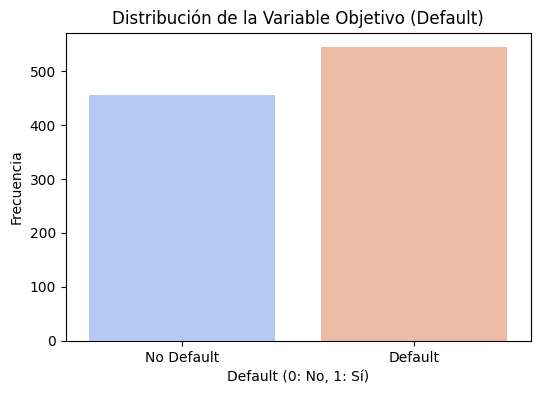

------------------------------------------------------------


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Default', data=df, palette='coolwarm')
plt.title('Distribución de la Variable Objetivo (Default)')
plt.xlabel('Default (0: No, 1: Sí)')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['No Default', 'Default'])
plt.show()
print("-" * 60)

######**Distribución de Características Numéricas**

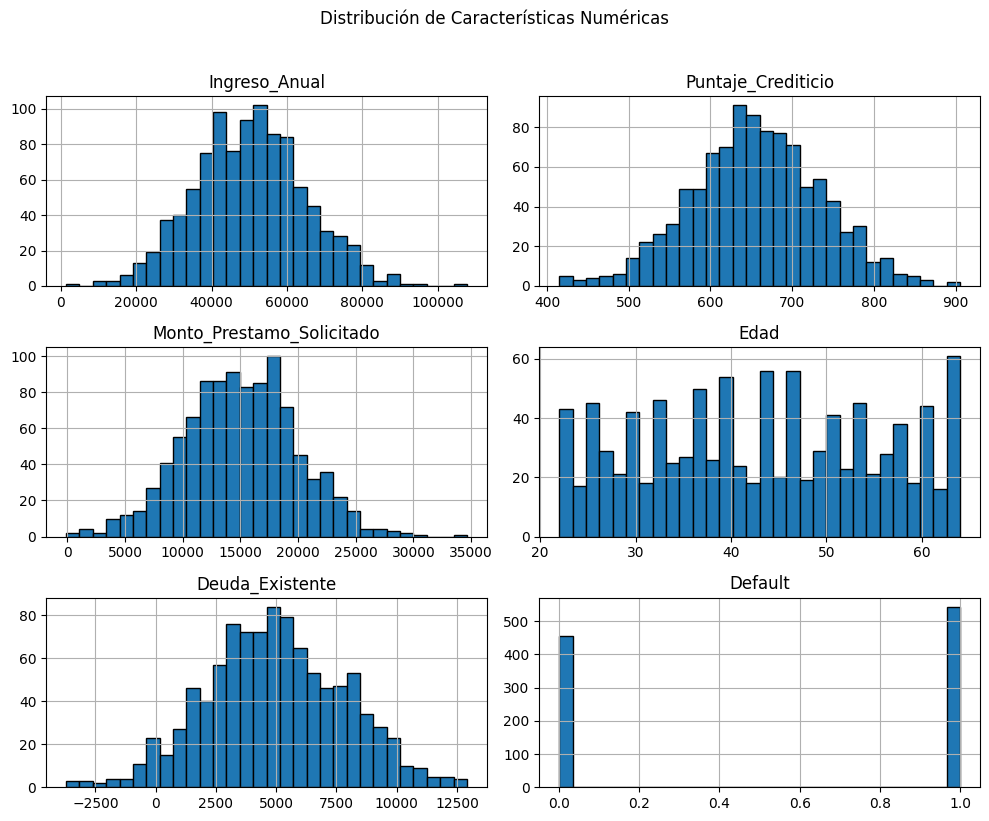

------------------------------------------------------------


In [9]:
# Histograma para cada característica numérica
df.hist(figsize=(10, 8), bins=30, edgecolor='black')
plt.suptitle('Distribución de Características Numéricas', y=1.02)
plt.tight_layout()
plt.show()
print("-" * 60)

#####**Análisis de Correlación**

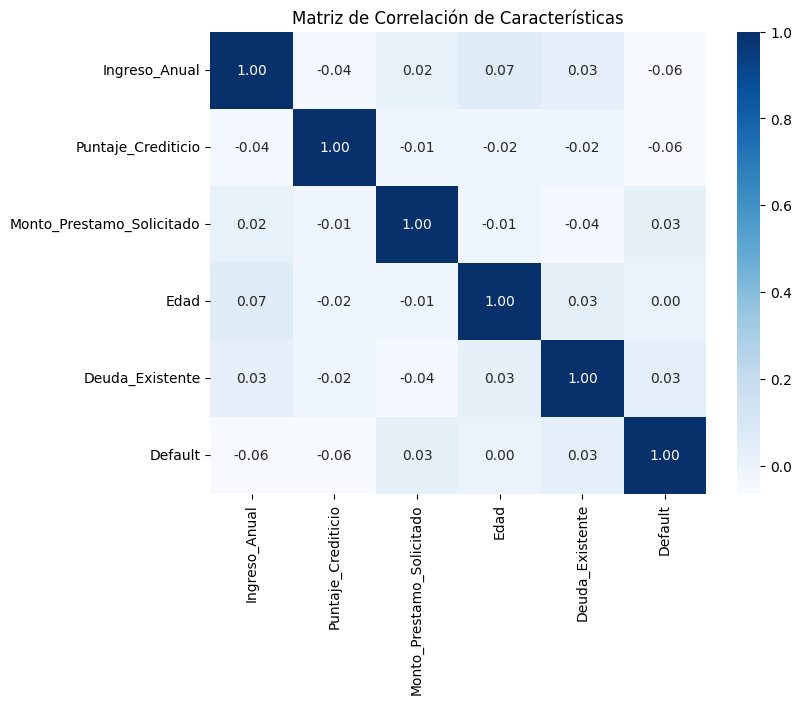

------------------------------------------------------------


In [10]:
# Matriz de correlación entre las características numéricas

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt=".2f")
plt.title('Matriz de Correlación de Características')
plt.show()
print("-" * 60)

#####**Box Plots para ver la relación entre características y 'Default'**

/tmp/ipython-input-3892289246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y=feature, data=df, palette='Blues')


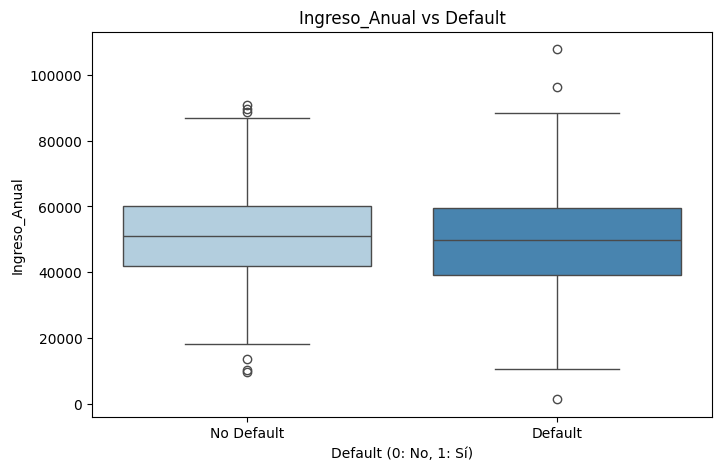

------------------------------------------------------------


/tmp/ipython-input-3892289246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y=feature, data=df, palette='Blues')


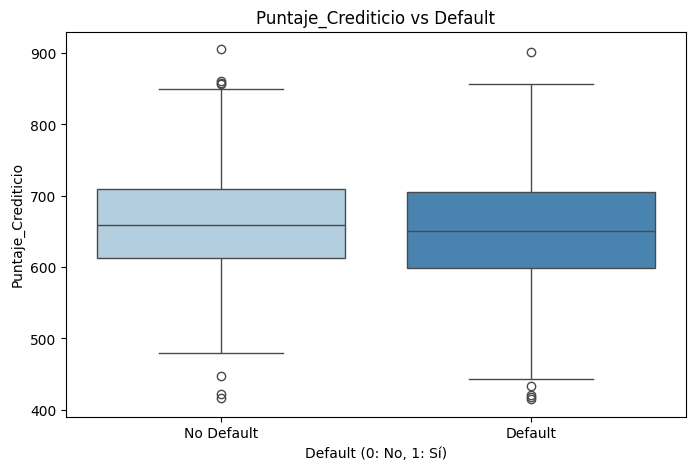

------------------------------------------------------------


/tmp/ipython-input-3892289246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y=feature, data=df, palette='Blues')


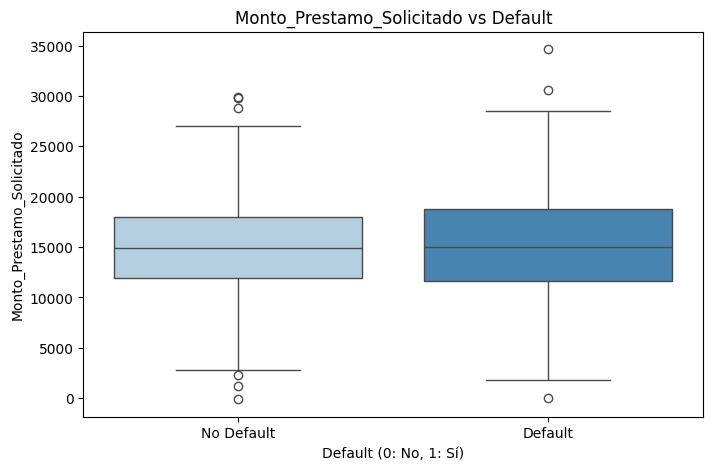

------------------------------------------------------------


/tmp/ipython-input-3892289246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y=feature, data=df, palette='Blues')


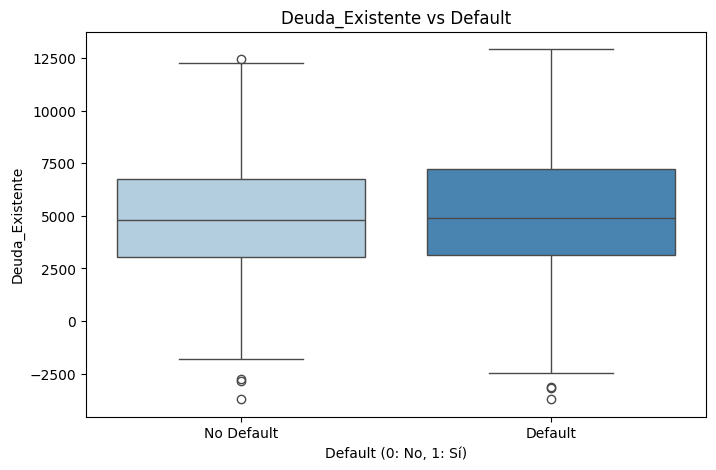

------------------------------------------------------------


In [11]:
# Seleccionando algunas características para visualizar con box plots

features_to_plot = ['Ingreso_Anual', 'Puntaje_Crediticio', 'Monto_Prestamo_Solicitado', 'Deuda_Existente']

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Default', y=feature, data=df, palette='Blues')
    plt.title(f'{feature} vs Default')
    plt.xlabel('Default (0: No, 1: Sí)')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['No Default', 'Default'])
    plt.show()
    print("-" * 60)

####**Preparación de los Datos**

In [12]:
# Definiendo las características (X) y la variable objetivo (y)
X = df[['Ingreso_Anual', 'Puntaje_Crediticio', 'Monto_Prestamo_Solicitado', 'Edad', 'Deuda_Existente']]
y = df['Default']

# Dividiendo los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#stratify=y asegura que la proporción de clases (Default/No Default) sea la misma en ambos conjuntos.

print(f"Tamaño del conjunto de entrenamiento X_train: {X_train.shape}")
print(f"Tamaño del conjunto de prueba X_test: {X_test.shape}")
print("-" * 60)

Tamaño del conjunto de entrenamiento X_train: (700, 5)
Tamaño del conjunto de prueba X_test: (300, 5)
------------------------------------------------------------


####**Estandarización de las Características**

In [13]:
# KNN es un algoritmo basado en distancias. Si las características tienen escalas muy diferentes,
# las características con rangos más grandes dominarán el cálculo de la distancia.
# La estandarización (media=0, desviación estándar=1) soluciona esto.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Aprende la escala de entrenamiento y la aplica
X_test_scaled = scaler.transform(X_test)       # Aplica la misma escala al conjunto de prueba

# Convirtiendo de nuevo a DataFrame para mantener los nombres de las columnas (opcional, pero útil)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Datos de entrenamiento escalados (primeras 5 filas):")
print(X_train_scaled_df.head())
print("-" * 60)

Datos de entrenamiento escalados (primeras 5 filas):
     Ingreso_Anual  Puntaje_Crediticio  Monto_Prestamo_Solicitado      Edad  \
544      -2.537867           -0.655347                   2.453576 -1.145990   
618       0.468083           -0.481510                   0.473274  0.667435   
19       -1.459404            0.359254                  -1.232625 -0.568991   
665       0.086743           -0.082651                  -1.361210  0.749863   
725      -0.208913            1.013476                   0.017187  0.749863   

     Deuda_Existente  
544         1.787757  
618        -1.770137  
19         -1.757343  
665         0.672480  
725        -1.077652  
------------------------------------------------------------


####**Construyendo y Entrenado el Modelo KNN**

In [14]:
# Se elige el valor de K.
# Una regla general es la raíz cuadrada del número de muestras de entrenamiento, o probar varios valores con validación cruzada.
# Aquí se usará un valor fijo.

k = 5 # Número de vecinos a considerar

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaled, y_train) # Entrenando el modelo con los datos escalados

print(f"Modelo KNN entrenado con K = {k} vecinos.")
print("-" * 60)

Modelo KNN entrenado con K = 5 vecinos.
------------------------------------------------------------


####**Realizando Predicciones**

In [15]:
y_pred = knn_model.predict(X_test_scaled)
y_pred_proba = knn_model.predict_proba(X_test_scaled) # Cálculo de probabilidad de pertenecer a cada clase

print("Predicciones para el conjunto de prueba (primeros 10):")
print(y_pred[:10])
print("\nProbabilidades de predicción (primeros 10):")
print(y_pred_proba[:10]) # La primera columna es prob de 0 (No Default), la segunda de 1 (Default)
print("-" * 60)

Predicciones para el conjunto de prueba (primeros 10):
[0 0 1 1 1 1 1 0 0 0]

Probabilidades de predicción (primeros 10):
[[0.8 0.2]
 [0.8 0.2]
 [0.2 0.8]
 [0.4 0.6]
 [0.2 0.8]
 [0.4 0.6]
 [0.  1. ]
 [1.  0. ]
 [0.6 0.4]
 [0.8 0.2]]
------------------------------------------------------------


####**Evaluación del Modelo a través de un reporte de clasificación**

In [16]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Reporte de Clasificación:
              precision    recall  f1-score   support

  No Default       0.45      0.42      0.43       137
     Default       0.53      0.56      0.55       163

    accuracy                           0.50       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.49      0.50      0.49       300



**support:**

Hay 137 casos reales de No Default en tu conjunto de prueba.
Hay 163 casos reales de Default en tu conjunto de prueba.
Esto indica un ligero desequilibrio en las clases, con un poco más de casos de 'Default'.

**accuracy (0.50 o 0.4967):**

En general, tu modelo predijo correctamente el 50% de las veces. Esto es muy bajo, apenas mejor que adivinar al azar en un problema binario (donde 50% sería el rendimiento esperado si las clases estuvieran perfectamente balanceadas). Indica que el modelo tiene dificultades para clasificar correctamente en general.

**Clase No Default:**

precision = 0.45: Cuando tu modelo predijo que un solicitante "No va a entrar en Default", solo fue correcto el 45% de las veces. Esto significa que hay bastantes Falsos Positivos (clientes que el modelo predijo como "No Default" pero que en realidad sí entraron en "Default").
recall = 0.42: De todos los clientes que realmente "No Default", tu modelo solo identificó correctamente al 42%. Esto significa que hay bastantes Falsos Negativos (clientes que realmente "No Default" pero que el modelo predijo erróneamente como "Default").
f1-score = 0.43: Es una puntuación baja, lo que confirma que el modelo no tiene un buen rendimiento en la identificación de esta clase.

**Clase Default:**

precision = 0.53: Cuando tu modelo predijo que un solicitante "va a entrar en Default", fue correcto el 53% de las veces. Es mejor que para "No Default", pero sigue siendo bastante bajo. Hay una cantidad considerable de Falsos Positivos aquí también (clientes que el modelo predijo como "Default" pero que en realidad "No Default").
recall = 0.56: De todos los clientes que realmente "Default", tu modelo identificó correctamente al 56%. Es la métrica más alta del reporte, pero sigue siendo solo un poco mejor que el azar. Indica que el modelo detecta un poco más de la mitad de los casos reales de impago.
f1-score = 0.55: Una puntuación modesta, indicando que el rendimiento para la clase 'Default' es un poco mejor que para 'No Default', pero aún débil.
macro avg y weighted avg:

Los promedios macro y ponderado son muy similares (alrededor de 0.49-0.50) porque el desequilibrio entre las clases es leve (137 vs 163). Esto significa que el rendimiento promedio del modelo es pobre, independientemente de cómo se ponderen las clases.

####**Generando Matriz de confusión**

Precisión del modelo (Accuracy): 0.4967

Matriz de Confusión:
[[57 80]
 [71 92]]


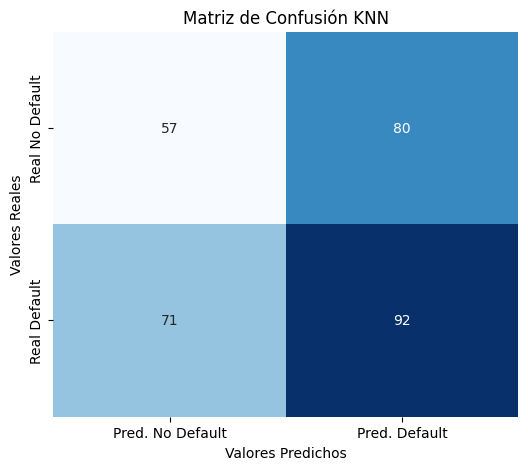

------------------------------------------------------------


In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo (Accuracy): {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Visualizando matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred. No Default', 'Pred. Default'],
            yticklabels=['Real No Default', 'Real Default'])
plt.title('Matriz de Confusión KNN')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

print("-" * 60)

####**Prediciendo Default para un Nuevo Solicitante (Ejemplo)**

  **Dando entrada a un nuevo solicitante con las siguientes características:**

In [18]:
# Dando entrada a un nuevo solicitante con las siguientes características:
nuevo_solicitante_data = {
    'Ingreso_Anual': [60000],
    'Puntaje_Crediticio': [720],
    'Monto_Prestamo_Solicitado': [10000],
    'Edad': [35],
    'Deuda_Existente': [2000]
}
nuevo_solicitante_df = pd.DataFrame(nuevo_solicitante_data)

#####**Estandarizando al nuevo solicitante usando el mismo scaler entrenado**

In [19]:
nuevo_solicitante_scaled = scaler.transform(nuevo_solicitante_df)

# Realizar la predicción
prediccion_nuevo = knn_model.predict(nuevo_solicitante_scaled)
prob_prediccion_nuevo = knn_model.predict_proba(nuevo_solicitante_scaled)

print(f"Características del nuevo solicitante:\n{nuevo_solicitante_df}")
if prediccion_nuevo[0] == 0:
    print(f"\nPredicción para el nuevo solicitante: NO HAY IMPAGO (Probabilidad: {prob_prediccion_nuevo[0][0]:.2f})")
else:
    print(f"\nPredicción para el nuevo solicitante: PROBABLE IMPAGO (Probabilidad: {prob_prediccion_nuevo[0][1]:.2f})")

print(f"Probabilidades completas: {prob_prediccion_nuevo[0]}")

Características del nuevo solicitante:
   Ingreso_Anual  Puntaje_Crediticio  Monto_Prestamo_Solicitado  Edad  \
0          60000                 720                      10000    35   

   Deuda_Existente  
0             2000  

Predicción para el nuevo solicitante: NO HAY IMPAGO (Probabilidad: 0.80)
Probabilidades completas: [0.8 0.2]
